Import the necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Load Dataset

In [2]:
df = pd.read_csv(r"C:\Users\slthi\Downloads\salesdata.csv")
df.head()

,Custkey,DateKey,Discount Amount,Invoice Date,Invoice Number,Item Class,Item Number,Item,Line Number,List Price,Order Number,Promised Delivery Date,Sales Amount,Sales Amount Based on List Price,Sales Cost Amount,Sales Margin Amount,Sales Price,Sales Quantity,Sales Rep,U/M
0,10016609,12/31/2019,398.73,2019/12/31,329568,P01,15640,Super Vegetable Oil,1000,163.47,122380,12/31/2019,418.62,817.35,102.99,315.63,83.72400,5,176,EA
1,10016609,12/31/2019,268.67,2019/12/31,329569,P01,31681,Golden Fajita French Fries,7000,275.37,123966,12/31/2019,282.07,550.74,117.45,164.62,141.03500,2,176,EA
2,10016609,12/31/2019,398.73,2019/12/31,329569,P01,15640,Super Vegetable Oil,4000,163.47,123966,12/31/2019,418.62,817.35,102.99,315.63,83.72400,5,176,EA
3,10016609,12/31/2019,466.45,2019/12/31,329569,P01,13447,High Top Oranges,3000,119.52,123966,12/31/2019,489.71,956.16,213.29,276.42,61.21375,8,176,EA
4,10016609,12/31/2019,515.51,2019/12/31,329569,P01,36942,Tell Tale New Potatos,9000,264.18,123966,12/31/2019,541.21,1056.72,290.56,250.65,135.30250,4,176,EA


Data Cleaning

In [3]:
date_columns = ['DateKey', 'Invoice Date', 'Promised Delivery Date']

# date columns in datetime format
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print(df[date_columns].dtypes)  

DateKey                   datetime64[ns]
Invoice Date              datetime64[ns]
Promised Delivery Date    datetime64[ns]
dtype: object


In [4]:
df.isnull().sum()

Custkey                                0
DateKey                                0
Discount Amount                        2
Invoice Date                           0
Invoice Number                         0
Item Class                          8285
Item Number                           40
Item                                   0
Line Number                            0
List Price                             0
Order Number                           0
Promised Delivery Date                 0
Sales Amount                           0
Sales Amount Based on List Price       0
Sales Cost Amount                      0
Sales Margin Amount                    0
Sales Price                            1
Sales Quantity                         0
Sales Rep                              0
U/M                                    0
dtype: int64

In [5]:
# remove duplicate rows
df.drop_duplicates(inplace=True)

In [6]:
# removing the columns that have no value for these attributes
df.dropna(subset=['Discount Amount', 'Sales Price', 'Item Number'], inplace=True)

In [7]:
df.isnull().sum()

Custkey                                0
DateKey                                0
Discount Amount                        0
Invoice Date                           0
Invoice Number                         0
Item Class                          8247
Item Number                            0
Item                                   0
Line Number                            0
List Price                             0
Order Number                           0
Promised Delivery Date                 0
Sales Amount                           0
Sales Amount Based on List Price       0
Sales Cost Amount                      0
Sales Margin Amount                    0
Sales Price                            0
Sales Quantity                         0
Sales Rep                              0
U/M                                    0
dtype: int64

In [ ]:
# item class - number os unique classes and their distribution
df['Item Class'].nunique()
df['Item Class'].value_counts()

Item Class
P01    56965
PO1       16
P02        1
P12        1
P13        1
P06        1
P15        1
P11        1
P08        1
P07        1
P10        1
P09        1
P14        1
P04        1
Name: count, dtype: int64

In [ ]:
# filling the missing values with the most repeating class 
df['Item Class'].fillna('P01', inplace=True)

In [ ]:
# rows, columns
df.shape

(65240, 20)

In [11]:
df.columns.tolist()

['Custkey',
 'DateKey',
 'Discount Amount',
 'Invoice Date',
 'Invoice Number',
 'Item Class',
 'Item Number',
 'Item',
 'Line Number',
 'List Price',
 'Order Number',
 'Promised Delivery Date',
 'Sales Amount',
 'Sales Amount Based on List Price',
 'Sales Cost Amount',
 'Sales Margin Amount',
 'Sales Price',
 'Sales Quantity',
 'Sales Rep',
 'U/M']

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65240 entries, 0 to 65279
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Custkey                           65240 non-null  int64         
 1   DateKey                           65240 non-null  datetime64[ns]
 2   Discount Amount                   65240 non-null  float64       
 3   Invoice Date                      65240 non-null  datetime64[ns]
 4   Invoice Number                    65240 non-null  int64         
 5   Item Class                        65240 non-null  object        
 6   Item Number                       65240 non-null  object        
 7   Item                              65240 non-null  object        
 8   Line Number                       65240 non-null  int64         
 9   List Price                        65240 non-null  float64       
 10  Order Number                      65240 non-null  i

In [ ]:
# statistical summary for numerical columns 
df.describe()

,Custkey,DateKey,Discount Amount,Invoice Date,Invoice Number,Line Number,List Price,Order Number,Promised Delivery Date,Sales Amount,Sales Amount Based on List Price,Sales Cost Amount,Sales Margin Amount,Sales Price,Sales Quantity,Sales Rep
count,6.524000e+04,65240,65240.000000,65240,65240.000000,65240.000000,65240.000000,65240.000000,65240,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000,65240.000000
mean,1.001770e+07,2018-06-11 17:57:26.376456192,1857.332863,2018-06-11 17:57:26.376456192,216294.567259,23725.376180,515.021356,180567.311695,2018-06-09 02:41:55.364806912,2853.161197,4710.494059,1662.048528,1191.112669,283.253429,45.107357,137.421735
min,1.000045e+07,2017-01-01 00:00:00,-255820.800000,2017-01-01 00:00:00,100080.000000,1000.000000,0.000000,100838.000000,2008-12-15 00:00:00,200.010000,0.000000,0.000000,-3932.930000,0.337341,1.000000,103.000000
25%,1.001272e+07,2017-07-24 00:00:00,246.280000,2017-07-24 00:00:00,117969.750000,3000.000000,181.560000,115281.000000,2017-07-23 00:00:00,308.362500,561.040000,167.810000,129.890000,100.030000,2.000000,113.000000
50%,1.001966e+07,2018-01-29 00:00:00,442.205000,2018-01-29 00:00:00,222906.000000,12000.000000,325.190000,203695.000000,2018-01-29 00:00:00,553.940000,999.750000,304.580000,246.480000,183.283929,3.000000,134.000000
75%,1.002351e+07,2019-06-17 00:00:00,1001.500000,2019-06-17 00:00:00,314325.000000,32000.000000,803.860000,218576.000000,2019-06-17 00:00:00,1279.752500,2321.400000,688.550000,578.220000,448.220000,8.000000,160.000000
max,1.002758e+07,2019-12-31 00:00:00,343532.660000,2019-12-31 00:00:00,332842.000000,344000.000000,2760.700000,321532.000000,2019-12-31 00:00:00,555376.000000,632610.160000,366576.000000,188800.000000,6035.000000,16000.000000,185.000000
std,7.175892e+03,NaN,9039.603327,NaN,94981.656013,32669.704672,449.146853,67612.713894,NaN,15169.133687,20702.762126,9559.467966,5862.610381,250.449245,429.796995,26.644355


In [14]:
# Creating Year, Month, Quarter, Day Columns in df
df['Invoice_Year'] = df['Invoice Date'].dt.year
df['Invoice_Month'] = df['Invoice Date'].dt.month
df['Invoice_Quarter'] = df['Invoice Date'].dt.quarter
df['Invoice_Day'] = df['Invoice Date'].dt.day

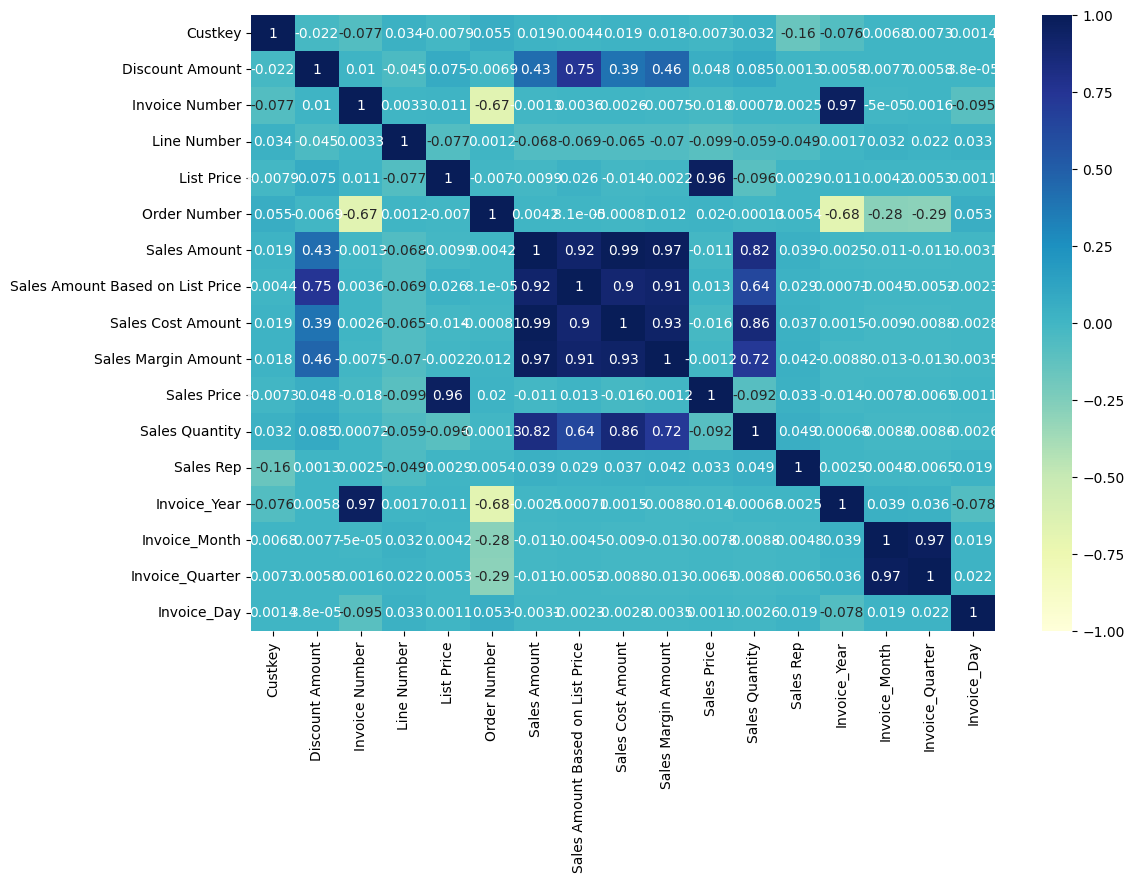

In [15]:
plt.figure(figsize=(12,8))

# only numeric columns
numeric_df = df.select_dtypes(include=['number'])

sns.heatmap(numeric_df.corr(method='pearson'), annot=True, vmin=-1, vmax=1, cmap='YlGnBu')
plt.show()

Observations:

1 Discount Amount is highly related to Sales Amount, Sales Cost Amount, Sales Amount Based on List Price & Sales Margin Amount and moderately related to Sales Quantity.

2- List Price highly related to sales price and has no relations with Sales amount, Sales cost amount, Sales amount based on list price & sales margin amount.

3- Sales quantity is moderately related to Sales amount, discount amount, sales margin amount.
Their is no relation Between Sales Rep and Sales Amount, Sales Margin Amount.


# Top 10 high sales day

In [16]:
DaySalesInsights = df.copy()
DaySalesInsights['Invoice_Date'] = pd.to_datetime(df['Invoice Date']).dt.date

In [17]:
top10sales = (
    DaySalesInsights.groupby('Invoice_Date')
    .agg({'Sales Amount': 'sum'}) 
    .sort_values('Sales Amount', ascending=False)
    .reset_index()
    .head(10)
)

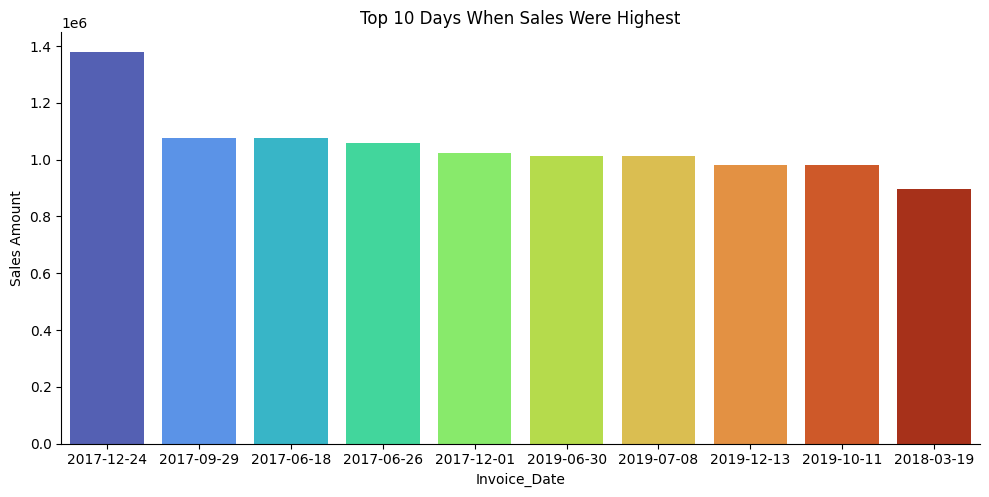

In [18]:
sns.catplot(
    y='Sales Amount',
    x='Invoice_Date',
    data=top10sales,
    aspect=2,
    palette='turbo',
    kind="bar",
    hue='Invoice_Date',  
    legend=False  
)

plt.title('Top 10 Days When Sales Were Highest')
plt.show()

# Top 10 high profit dates

In [19]:
top10profits = (
    DaySalesInsights.groupby('Invoice_Date')
    .agg({'Sales Margin Amount': 'sum'})  
    .sort_values('Sales Margin Amount', ascending=False)
    .reset_index()
    .head(10)
)

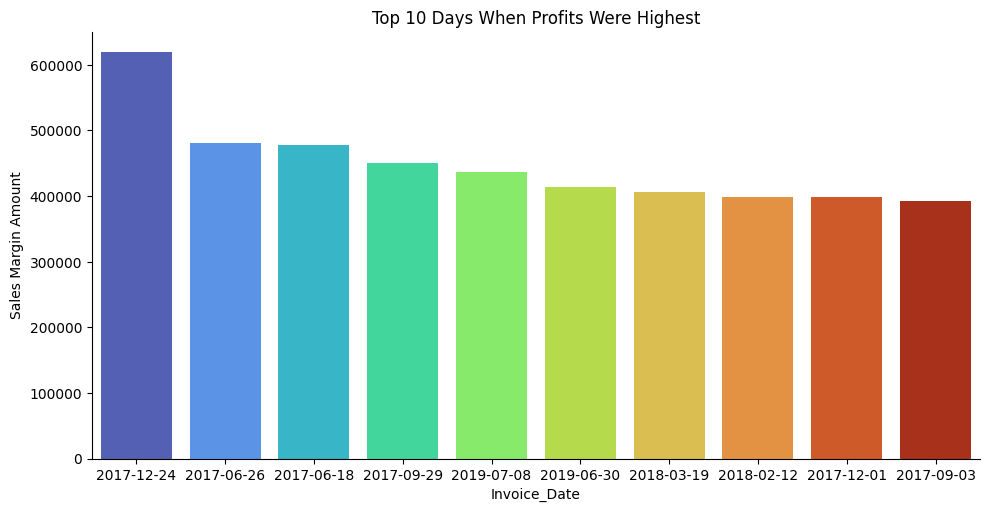

In [20]:
sns.catplot(
    y='Sales Margin Amount',
    x='Invoice_Date',
    data=top10profits,
    aspect=2,
    palette='turbo',
    kind="bar",
    hue='Invoice_Date',  
    legend=False 
)

plt.title('Top 10 Days When Profits Were Highest')
plt.show()

# Top 10 highest quantity sales

In [ ]:
highqty = (
    DaySalesInsights.groupby('Invoice_Date')
    .agg({'Sales Quantity': 'sum'})  
    .sort_values('Sales Quantity', ascending=False)
    .reset_index()
    .head(10)
)

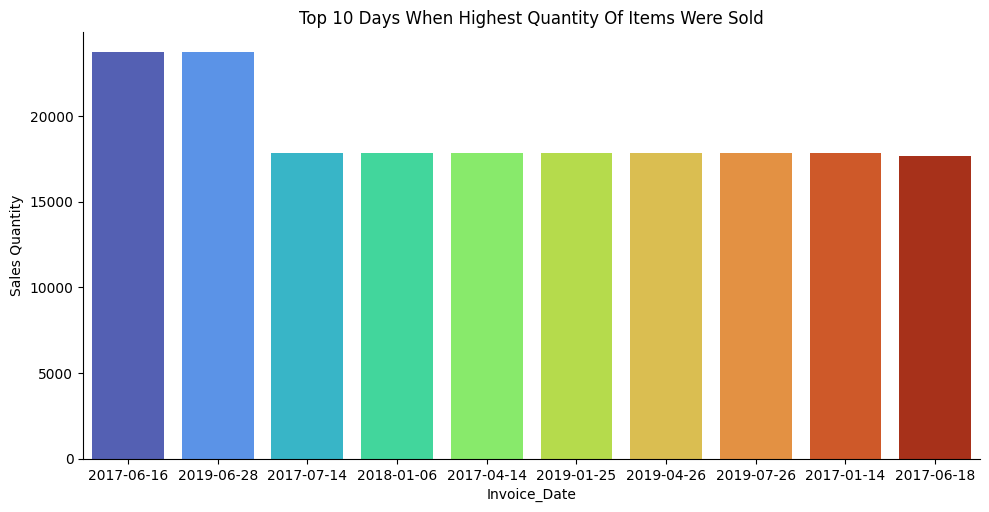

In [22]:
sns.catplot(
    y='Sales Quantity',
    x='Invoice_Date',
    data=highqty,
    aspect=2,
    palette='turbo',
    kind="bar",
    hue='Invoice_Date',  
    legend=False  
)

plt.title('Top 10 Days When Highest Quantity Of Items Were Sold')
plt.show()

# Top 10 days with most customers

In [23]:
MostCust = (
    DaySalesInsights.groupby('Invoice_Date')
    .agg({'Custkey': 'count'})  
    .sort_values('Custkey', ascending=False)
    .reset_index()
    .head(10)
)

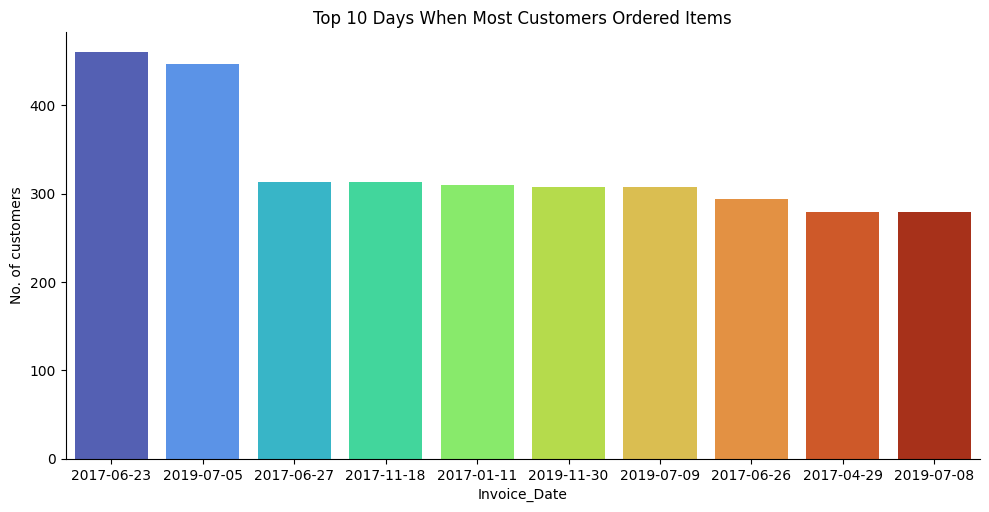

In [24]:
sns.catplot(
    y='Custkey',
    x='Invoice_Date',
    data=MostCust,
    aspect=2,
    palette='turbo',
    kind="bar",
    hue='Invoice_Date',  
    legend=False 
)

plt.title('Top 10 Days When Most Customers Ordered Items')
plt.ylabel('No. of customers')
plt.show()

## Customer Analysis: Repeat vs New Customers

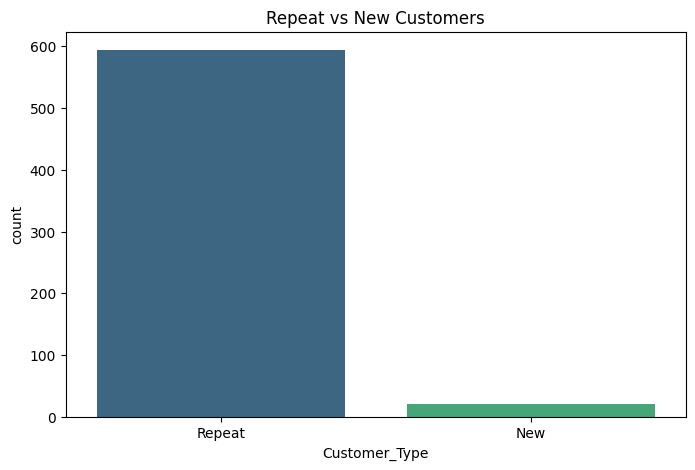

In [26]:
repeat_customers = df.groupby('Custkey').agg({'Invoice Number': 'count'}).reset_index()
repeat_customers['Customer_Type'] = repeat_customers['Invoice Number'].apply(lambda x: 'Repeat' if x > 1 else 'New')

plt.figure(figsize=(8,5))
sns.countplot(x='Customer_Type', data=repeat_customers, hue='Customer_Type', palette='viridis', legend=False)  # Fix applied
plt.title('Repeat vs New Customers')
plt.show()

## Product Performance Analysis
Top 10 Best-Selling Items by Quantity


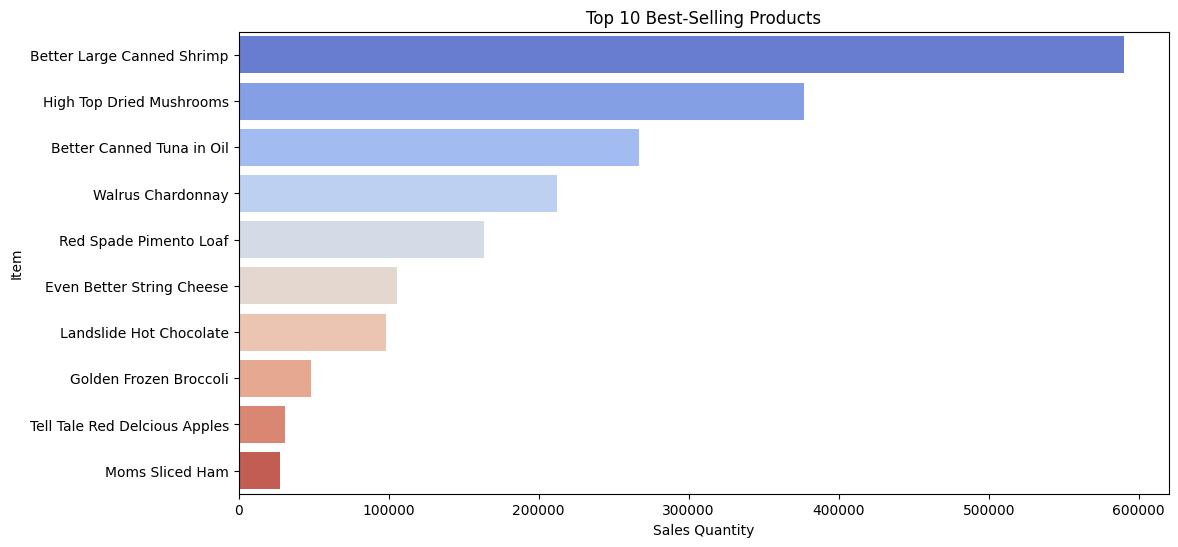

In [27]:
top_products = df.groupby('Item').agg({'Sales Quantity': 'sum'}).reset_index()
top_products = top_products.sort_values('Sales Quantity', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(y='Item', x='Sales Quantity', data=top_products, hue='Item', palette='coolwarm', legend=False)  # Fix applied
plt.title('Top 10 Best-Selling Products')
plt.show()

## Monthly Sales Trend

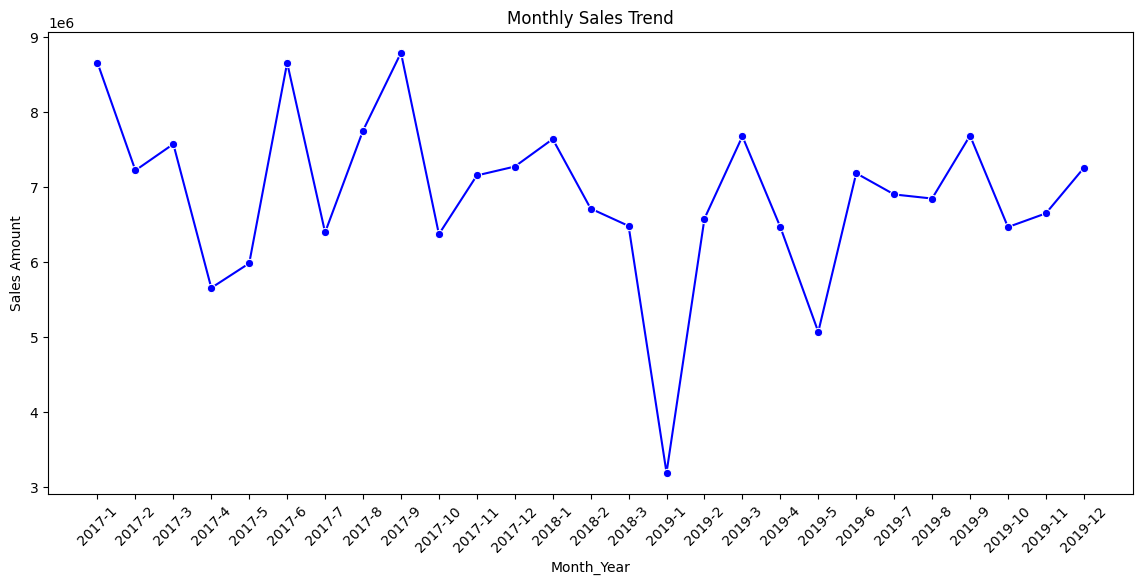

In [28]:
monthly_sales = df.groupby(['Invoice_Year', 'Invoice_Month']).agg({'Sales Amount': 'sum'}).reset_index()
monthly_sales['Month_Year'] = monthly_sales['Invoice_Year'].astype(str) + '-' + monthly_sales['Invoice_Month'].astype(str)

plt.figure(figsize=(14,6))
sns.lineplot(x='Month_Year', y='Sales Amount', data=monthly_sales, marker='o', color='b')
plt.xticks(rotation=45)
plt.title('Monthly Sales Trend')
plt.show()

## Seasonal Trends (Quarterly/Weekly Patterns)

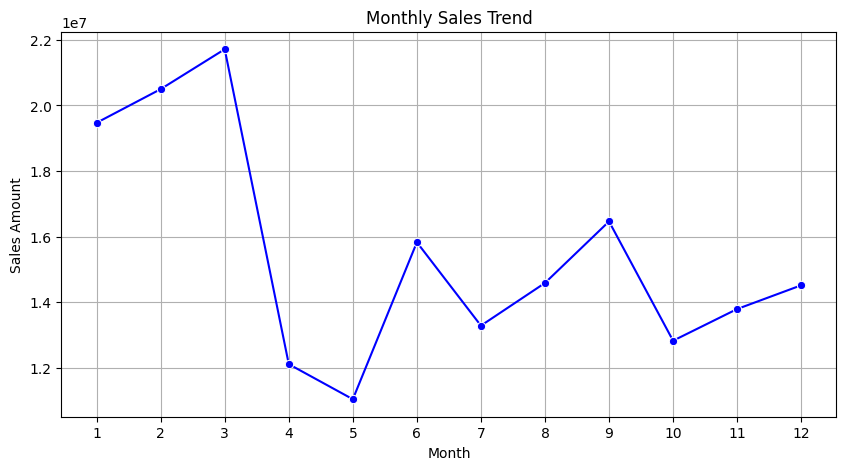

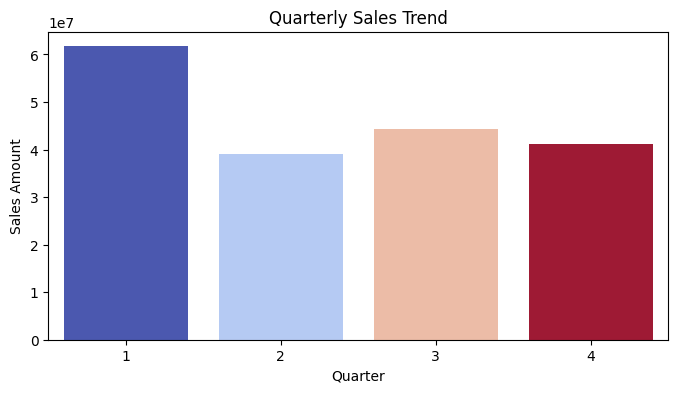

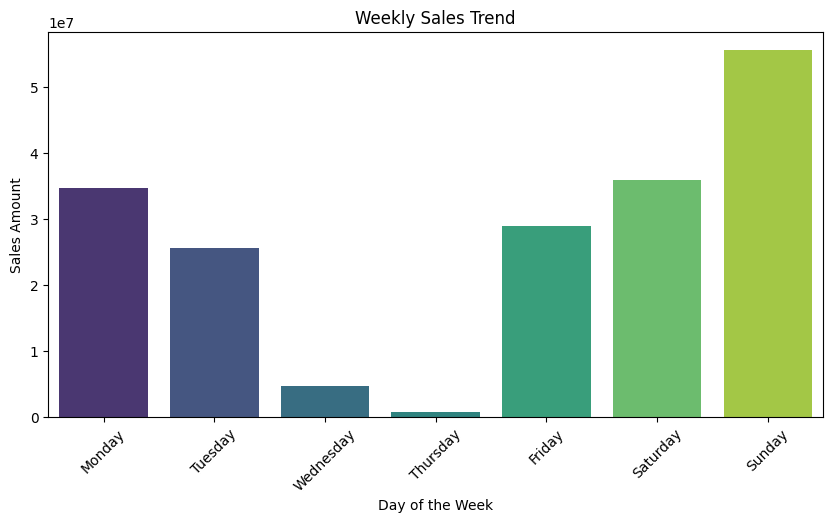

In [29]:
# Monthly Sales Trend
monthly_sales = df.groupby('Invoice_Month').agg({'Sales Amount': 'sum'}).reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(x='Invoice_Month', y='Sales Amount', data=monthly_sales, marker='o', color='b')
plt.xticks(range(1, 13))  
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales Amount')
plt.grid()
plt.show()

# Quarterly Sales Trend 
quarterly_sales = df.groupby('Invoice_Quarter').agg({'Sales Amount': 'sum'}).reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='Invoice_Quarter', y='Sales Amount', data=quarterly_sales, hue='Invoice_Quarter', palette='coolwarm', legend=False)  
plt.title('Quarterly Sales Trend')
plt.xlabel('Quarter')
plt.ylabel('Sales Amount')
plt.show()

# Weekly Sales Trend 
df['Invoice_Weekday'] = df['Invoice Date'].dt.day_name()
weekly_sales = df.groupby('Invoice_Weekday').agg({'Sales Amount': 'sum'}).reset_index()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales = weekly_sales.set_index('Invoice_Weekday').reindex(weekday_order).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='Invoice_Weekday', y='Sales Amount', data=weekly_sales, hue='Invoice_Weekday', palette='viridis', legend=False)  
plt.title('Weekly Sales Trend')
plt.xlabel('Day of the Week')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.show()

## Impact of Discounts on Sales

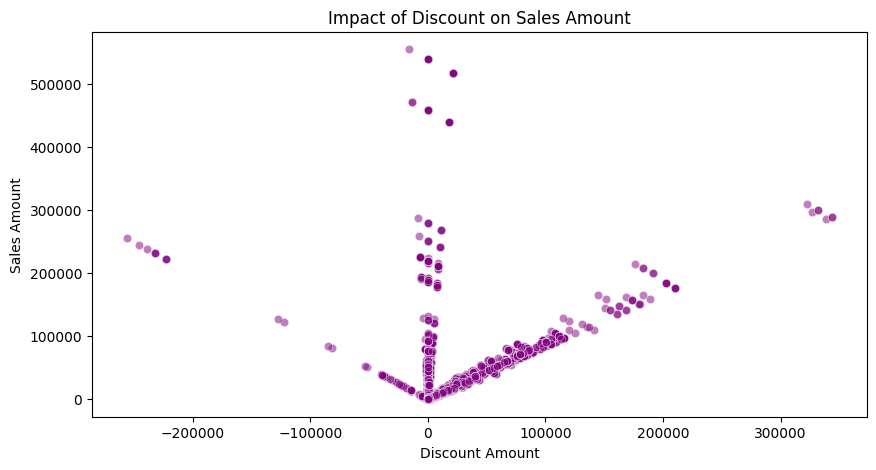

Correlation between Discount and Sales Amount:
                 Discount Amount  Sales Amount
Discount Amount         1.000000      0.425849
Sales Amount            0.425849      1.000000


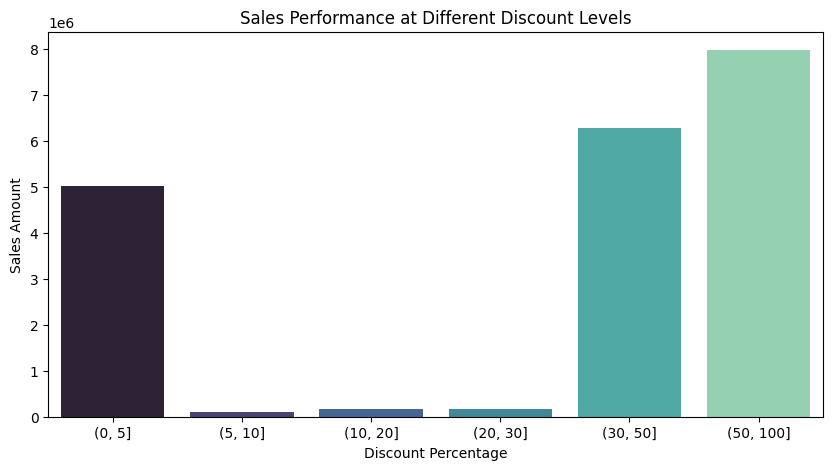

In [30]:
# Scatter Plot: Discount vs Sales Amount
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['Discount Amount'], y=df['Sales Amount'], alpha=0.5, color='purple')
plt.title('Impact of Discount on Sales Amount')
plt.xlabel('Discount Amount')
plt.ylabel('Sales Amount')
plt.show()

# Correlation between Discount and Sales
corr_discount_sales = df[['Discount Amount', 'Sales Amount']].corr()
print("Correlation between Discount and Sales Amount:")
print(corr_discount_sales)

# Sales Performance at Different Discount Levels 
df['Discount_Percentage'] = (df['Discount Amount'] / df['List Price']) * 100
discount_groups = df.groupby(pd.cut(df['Discount_Percentage'], bins=[0, 5, 10, 20, 30, 50, 100])).agg({'Sales Amount': 'sum'}).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='Discount_Percentage', y='Sales Amount', data=discount_groups, hue='Discount_Percentage', palette='mako', legend=False)  
plt.title('Sales Performance at Different Discount Levels')
plt.xlabel('Discount Percentage')
plt.ylabel('Sales Amount')
plt.show()

## Predictive Analytics

## Sales Forecasting (Time Series Analysis)

In [ ]:
# Aggregate sales by month
df['Invoice_Date'] = pd.to_datetime(df['Invoice Date'])  
monthly_sales = df.groupby(df['Invoice_Date'].dt.to_period('M')).agg({'Sales Amount': 'sum'}).reset_index()

# Convert period to datetime
monthly_sales['Invoice_Date'] = monthly_sales['Invoice_Date'].astype(str) + '-01'
monthly_sales['Invoice_Date'] = pd.to_datetime(monthly_sales['Invoice_Date'])

# Check stationarity using ADF Test
result = adfuller(monthly_sales['Sales Amount'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Stationary" if result[1] < 0.05 else "Not Stationary")

# Fit ARIMA Model
model = sm.tsa.ARIMA(monthly_sales['Sales Amount'], order=(5,1,0))  # (p,d,q) - tune these values
model_fit = model.fit()

# Forecast future sales
forecast = model_fit.forecast(steps=6)  # Predict next 6 months

# Plot results
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['Invoice_Date'], monthly_sales['Sales Amount'], label='Actual Sales')
plt.plot(pd.date_range(monthly_sales['Invoice_Date'].iloc[-1], periods=7, freq='M')[1:], forecast, label='Forecast', linestyle='dashed', color='red')
plt.legend()
plt.title("Sales Forecast for Next 6 Months")
plt.show()


## Impact of Discounts on Sales (Regression Analysis)

In [ ]:
# Prepare data
X = df[['Discount Amount']]  # Feature
y = df['Sales Amount']       # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(f"R² Score: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

# Visualize
plt.figure(figsize=(10,5))
sns.scatterplot(x=X_test['Discount Amount'], y=y_test, label='Actual')
sns.lineplot(x=X_test['Discount Amount'], y=y_pred, color='red', label='Predicted')
plt.title("Impact of Discounts on Sales")
plt.show()


## Customer Segmentation (Clustering)

In [ ]:
# Aggregate customer data
customer_df = df.groupby('Custkey').agg({'Sales Amount': 'sum', 'Invoice Number': 'count'}).reset_index()
customer_df.rename(columns={'Invoice Number': 'Num_Purchases'}, inplace=True)

# Add Avg Order Value
customer_df['Avg_Order_Value'] = customer_df['Sales Amount'] / customer_df['Num_Purchases']

# Normalize data
scaler = StandardScaler()
customer_df_scaled = scaler.fit_transform(customer_df[['Sales Amount', 'Num_Purchases', 'Avg_Order_Value']])

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(customer_df_scaled)

# Visualize Clusters
plt.figure(figsize=(10,5))
sns.scatterplot(x=customer_df['Num_Purchases'], y=customer_df['Sales Amount'], hue=customer_df['Cluster'], palette='viridis')
plt.title("Customer Segmentation")
plt.show()
